In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Import L0 modules
from l0.layers import L0Linear, L0Conv2d, SparseMLP
from l0.gates import FeatureGate, SampleGate
from l0.penalties import (
    compute_l0_penalty,
    get_sparsity_stats,
    TemperatureScheduler,
    update_temperatures
)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 2. LeNet-5 on MNIST with L0

Reproducing a simplified version of the LeNet experiments from the paper.

In [3]:
class L0LeNet5(nn.Module):
    """LeNet-5 with L0 regularization on conv and fc layers."""
    
    def __init__(self, init_sparsity=0.5, temperature=0.5):
        super().__init__()
        # Conv layers with L0
        self.conv1 = L0Conv2d(1, 6, 5, init_sparsity=init_sparsity, temperature=temperature)
        self.conv2 = L0Conv2d(6, 16, 5, init_sparsity=init_sparsity, temperature=temperature)
        
        # FC layers with L0
        self.fc1 = L0Linear(16 * 4 * 4, 120, init_sparsity=init_sparsity, temperature=temperature)
        self.fc2 = L0Linear(120, 84, init_sparsity=init_sparsity, temperature=temperature)
        self.fc3 = L0Linear(84, 10, init_sparsity=init_sparsity, temperature=temperature)
        
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def get_l0_loss(self):
        l0_loss = 0
        for module in self.modules():
            if hasattr(module, 'get_l0_penalty'):
                l0_loss = l0_loss + module.get_l0_penalty()
        return l0_loss
    
    def get_layer_sparsities(self):
        sparsities = {}
        for name, module in self.named_modules():
            if hasattr(module, 'get_sparsity'):
                sparsities[name] = module.get_sparsity()
        return sparsities

lenet = L0LeNet5(init_sparsity=0.1, temperature=0.5).to(device)
print("Initial layer sparsities:")
for name, sparsity in lenet.get_layer_sparsities().items():
    print(f"  {name}: {sparsity:.2%}")

Initial layer sparsities:
  conv1: 3.24%
  conv1.weight_gates: 3.24%
  conv2: 3.24%
  conv2.weight_gates: 3.24%
  fc1: 3.24%
  fc1.weight_gates: 3.24%
  fc2: 3.24%
  fc2.weight_gates: 3.24%
  fc3: 3.24%
  fc3.weight_gates: 3.24%


In [4]:
# Training LeNet with L0 and temperature annealing
optimizer = optim.Adam(lenet.parameters(), lr=0.001)
temp_scheduler = TemperatureScheduler(initial_temp=1.0, final_temp=0.05, anneal_epochs=20)
l0_lambda = 1e-3

train_losses = []
layer_sparsities = {name: [] for name in lenet.get_layer_sparsities().keys()}

for epoch in range(30):
    # Update temperature
    temp = temp_scheduler.get_temperature(epoch)
    update_temperatures(lenet, temp)
    
    # Training
    lenet.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        output = lenet(batch_x)
        ce_loss = F.cross_entropy(output, batch_y)
        l0_loss = lenet.get_l0_loss()
        total_loss = ce_loss + l0_lambda * l0_loss
        
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    
    # Track sparsities
    for name, sparsity in lenet.get_layer_sparsities().items():
        layer_sparsities[name].append(sparsity)
    
    if (epoch + 1) % 10 == 0:
        avg_sparsity = np.mean(list(lenet.get_layer_sparsities().values()))
        print(f"Epoch {epoch+1}: Loss={train_losses[-1]:.4f}, Temp={temp:.3f}, Avg Sparsity={avg_sparsity:.2%}")

Epoch 10: Loss=43.4486, Temp=0.260, Avg Sparsity=6.36%


Epoch 20: Loss=39.9766, Temp=0.058, Avg Sparsity=12.07%


Epoch 30: Loss=37.6803, Temp=0.050, Avg Sparsity=14.76%


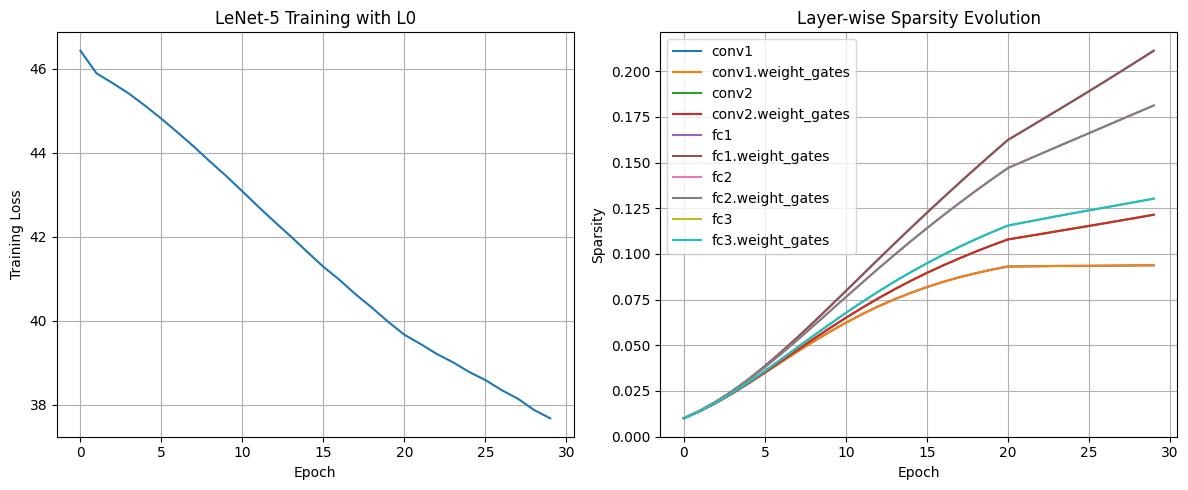


Final layer sparsities:
  conv1: 9.38% sparse (135/150 active)
  conv2: 12.15% sparse (2108/2400 active)
  fc1: 21.12% sparse (24230/30720 active)
  fc2: 18.13% sparse (8252/10080 active)
  fc3: 13.03% sparse (730/840 active)

Overall sparsity: 19.77%
Compression ratio: 1.2x


In [5]:
# Visualize layer-wise sparsity evolution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('LeNet-5 Training with L0')
plt.grid(True)

plt.subplot(1, 2, 2)
for name, sparsity_history in layer_sparsities.items():
    plt.plot(sparsity_history, label=name)
plt.xlabel('Epoch')
plt.ylabel('Sparsity')
plt.title('Layer-wise Sparsity Evolution')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Final sparsities
print("\nFinal layer sparsities:")
total_params = 0
active_params = 0
for name, module in lenet.named_modules():
    if hasattr(module, 'get_sparsity'):
        sparsity = module.get_sparsity()
        if hasattr(module, 'weight'):
            n_params = module.weight.numel()
            n_active = int(n_params * (1 - sparsity))
            total_params += n_params
            active_params += n_active
            print(f"  {name}: {sparsity:.2%} sparse ({n_active}/{n_params} active)")

print(f"\nOverall sparsity: {1 - active_params/total_params:.2%}")
print(f"Compression ratio: {total_params/active_params:.1f}x")